<a href="https://colab.research.google.com/github/kshipra-jadav/ztm-dl/blob/master/Transfer_Learning_with_Tensorflow_(Part_3)_ZTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision mini)

## Getting the helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-13 01:58:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-13 01:58:00 (78.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Getting the dataset! (101 Food Classes!)

> The dataset downloaded has 101 food classes but only 10% of the training data

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-08-13 01:58:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  39.9MB/s    in 40s     

2023-08-13 01:58:40 (38.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
from helper_functions import unzip_data

unzip_data("101_food_classes_10_percent.zip")

In [4]:
base_dir = "101_food_classes_10_percent"
train_dir = f"{base_dir}/train"
test_dir = f"{base_dir}/test"

In [5]:
from helper_functions import walk_through_dir

walk_through_dir(base_dir)

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 ima

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data_10pc = image_dataset_from_directory(directory=train_dir,
                                               image_size=(224, 224),
                                               label_mode="categorical")
test_data_10pc = image_dataset_from_directory(directory=test_dir,
                                              image_size=(224, 224),
                                              label_mode="categorical")

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Training A Big Transfer Learning Model on 10% of 101 Food Classes
Here are the steps to be taken :-
1. Create a ModelCheckpoint callback
2. Create data augmentation layer
3. Build a headless (no top layers) functional EfficientNetB0 backboned model
4. Compile the model
5. Feature extract for 5 epochs

## Creating ModelCheckpoint Callback

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "101_classes_10_percent_checkpoints"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

## Creating Data Augmentation Layer

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomWidth, RandomTranslation, RandomBrightness, RandomCrop, RandomZoom, RandomHeight, RandomRotation, RandomFlip

data_augmentation = Sequential([
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.2),
    RandomFlip("horizontal")
], name="data_aug_layer")

## Creating a headless functional EfficientNet B0 model

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_avg")(x)
outputs = Dense(101, activation="softmax")(x)

model_1 = Model(inputs, outputs, name="model_1")

In [15]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential)  (None, None, None, 3)    0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg (GlobalAveragePo  (None, 1280)             0         
 oling2D)                                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [16]:
0.15 * len(test_data_10pc)

118.5

In [19]:
model_1.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

model_1_history = model_1.fit(train_data_10pc,
                              validation_data=test_data_10pc,
                              validation_steps = int(0.15 * len(test_data_10pc)),
                              epochs=5,
                              callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 104s 406ms/step - loss: 3.1640 - accuracy: 0.3092 - val_loss: 2.2256 - val_accuracy: 0.4899
Epoch 2/5
237/237 [==============================] - 78s 325ms/step - loss: 2.2089 - accuracy: 0.4932 - val_loss: 1.8387 - val_accuracy: 0.5448
Epoch 3/5
237/237 [==============================] - 68s 287ms/step - loss: 1.8978 - accuracy: 0.5460 - val_loss: 1.6896 - val_accuracy: 0.5704
Epoch 4/5
237/237 [==============================] - 62s 258ms/step - loss: 1.6922 - accuracy: 0.5860 - val_loss: 1.6315 - val_accuracy: 0.5752
Epoch 5/5
237/237 [==============================] - 56s 234ms/step - loss: 1.5368 - accuracy: 0.6279 - val_loss: 1.5827 - val_accuracy: 0.5781


In [20]:
model_1.evaluate(test_data_10pc)

790/790 [==============================] - 63s 79ms/step - loss: 1.5891 - accuracy: 0.5807


[1.5891075134277344, 0.5806732773780823]

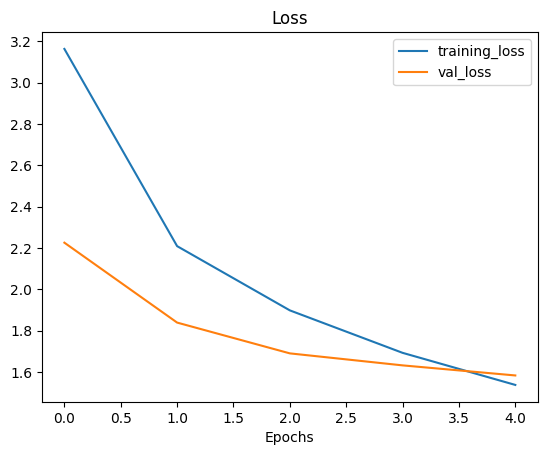

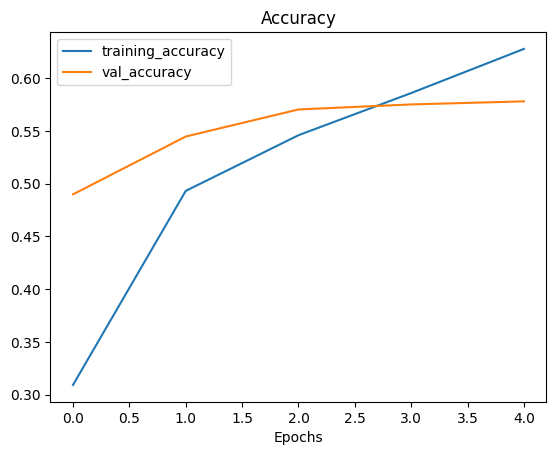

In [21]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_1_history)

## Fine Tuning Previous Model By Unfreezing Some Layers

In [31]:
from tensorflow.keras.models import clone_model

model_2 = clone_model(model_1)

model_2.set_weights(model_1.get_weights())

In [32]:
model_2.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

model_2.evaluate(test_data_10pc)

790/790 [==============================] - 64s 76ms/step - loss: 1.5891 - accuracy: 0.5807


[1.589107632637024, 0.5806732773780823]

In [30]:
model_2.layers[2].trainable = True

for layer in model_2.layers[2].layers[:-5]:
  layer.trainable = False

for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [34]:
from tensorflow.keras.optimizers import Adam

model_2.compile(optimizer=Adam(learning_rate=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

model_2_history = model_2.fit(train_data_10pc,
                              validation_data=test_data_10pc,
                              validation_steps=int(0.15 * len(test_data_10pc)),
                              epochs=len(model_1_history.epoch) + 5,
                              initial_epoch=model_1_history.epoch[-1],
                              callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 64s 238ms/step - loss: 1.3955 - accuracy: 0.6602 - val_loss: 1.5549 - val_accuracy: 0.5879
Epoch 6/10
237/237 [==============================] - 52s 219ms/step - loss: 1.3846 - accuracy: 0.6627 - val_loss: 1.5536 - val_accuracy: 0.5919
Epoch 7/10
237/237 [==============================] - 51s 212ms/step - loss: 1.3549 - accuracy: 0.6723 - val_loss: 1.5410 - val_accuracy: 0.5940
Epoch 8/10
237/237 [==============================] - 49s 203ms/step - loss: 1.3422 - accuracy: 0.6731 - val_loss: 1.5392 - val_accuracy: 0.5945
Epoch 9/10
237/237 [==============================] - 47s 198ms/step - loss: 1.3363 - accuracy: 0.6845 - val_loss: 1.5362 - val_accuracy: 0.5967
Epoch 10/10
237/237 [==============================] - 47s 197ms/step - loss: 1.3246 - accuracy: 0.6771 - val_loss: 1.5311 - val_accuracy: 0.5969


In [35]:
model_2.evaluate(test_data_10pc)

790/790 [==============================] - 66s 83ms/step - loss: 1.5443 - accuracy: 0.5950


[1.544313907623291, 0.5949702858924866]

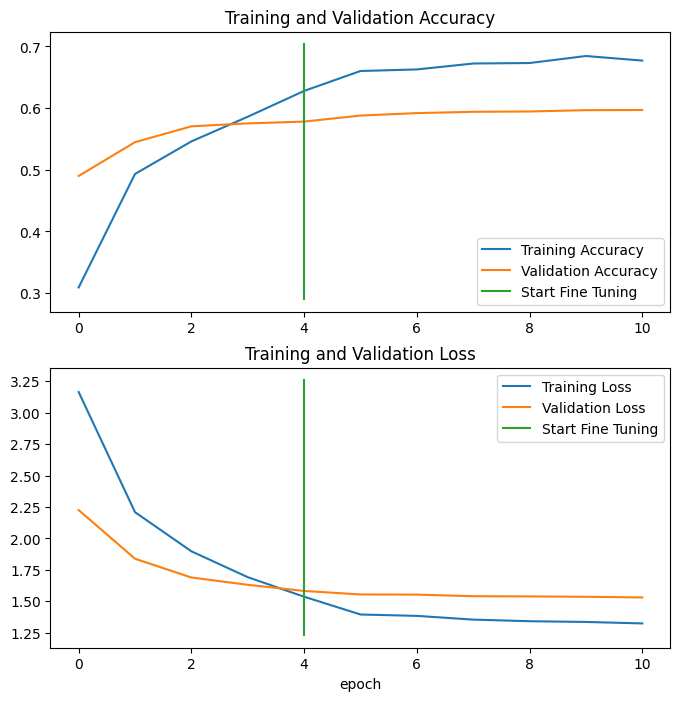

In [36]:
from helper_functions import compare_historys

compare_historys(model_1_history, model_2_history)